In [0]:
import tensorflow as tf
keras, L = tf.keras, tf.keras.layers

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from skimage.transform import resize

In [0]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
del X, y

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1)) / 255.
y_train = y_train.astype(int)

X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1)) / 255.
y_test = y_test.astype(int)

In [0]:
imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow(X_train, y_train, shuffle=True, batch_size=32)
val = imagegen.flow(X_test, y_test, shuffle=False, batch_size=32)

In [0]:
class RevNet(tf.keras.Model):
  def __init__(self):
    super(RevNet, self).__init__()
    self._encoder = self._construct_encoder()
    self._decoder = self._construct_decoder()
    self._prediction = self._construct_prediction()

  def _construct_encoder(self):
    encoder = tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
            tf.keras.layers.Dense(28*28, activation="sigmoid"),
            tf.keras.layers.Dense(28*28, activation="sigmoid")
        ],
        name="encoder")
    return encoder

  def _construct_decoder(self):
    decoder = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(28*28, activation="sigmoid", input_shape=(28*28,)),
            tf.keras.layers.Dense(28*28)
        ],
        name="decoder")
    return decoder

  def _construct_prediction(self):
    prediction = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(10, input_shape=(10,))
        ],
        name="prediction")
    return prediction

  def call(self, inputs, training=True):
    predicted_array = self._encoder(inputs, training)
    logits = predicted_array[:, :10]
    nuisance = predicted_array[:, 10:]
    pred_logits = self._prediction(logits)
    pred_image = self._decoder(predicted_array, training)

    return logits, nuisance, pred_logits, pred_image

In [15]:
model = RevNet()
model.build((1, 28, 28, 1))
model.summary()

Model: "rev_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 784)               1230880   
_________________________________________________________________
decoder (Sequential)         (None, 784)               1230880   
_________________________________________________________________
prediction (Sequential)      (None, 10)                110       
Total params: 2,461,870
Trainable params: 2,461,870
Non-trainable params: 0
_________________________________________________________________


Epoch:  20
Training loss mse: 5.9786754036395e-07, Training loss ce: 0.3726981580257416, Training acc over epoch: 0.8888393044471741
Val loss mse: 5.808809646623558e-07, Val loss ce: 0.3679417073726654, Val acc over epoch: 0.8937857151031494


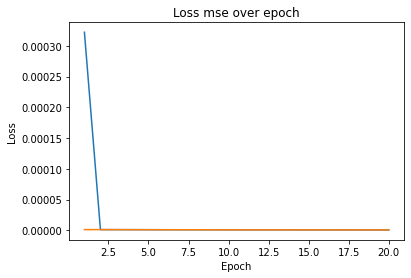

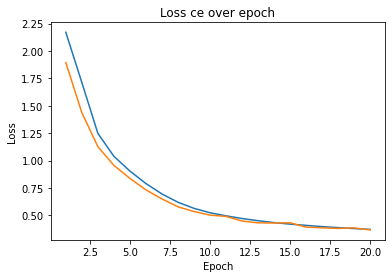

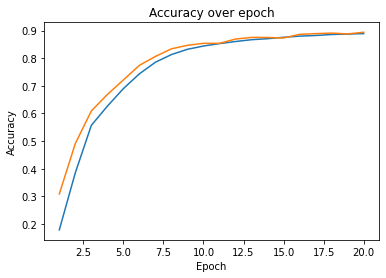

In [16]:
from IPython.display import clear_output
from tqdm import tqdm

max_val_acc = None

train_losses_mse = []
val_losses_mse = []

train_losses_ce = []
val_losses_ce = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

for epoch in range(20):
    train_mean_loss_mse = tf.keras.metrics.Mean()
    train_mean_loss_ce = tf.keras.metrics.Mean()
    val_mean_loss_mse = tf.keras.metrics.Mean()
    val_mean_loss_ce = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(len(X_train) / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        with tf.GradientTape() as tape:
          logits, nuisance, pred_logits, pred_images = model(x_batch_train, training=True)

          ce_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
          cross_ent = ce_fn(y_true=y_batch_train, y_pred=pred_logits)

          mse = tf.keras.losses.MSE(pred_images, tf.reshape(x_batch_train, (-1, 28*28)))

          loss = mse + cross_ent

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        train_acc_metric(y_batch_train, pred_logits)
        train_mean_loss_mse(mse)
        train_mean_loss_ce(cross_ent)

    for step in range(int(np.ceil(len(X_test) / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, nuisance, pred_logits, pred_images = model(x_batch_val, training=False)

        ce_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        cross_ent = ce_fn(y_true=y_batch_val, y_pred=pred_logits)

        mse = tf.keras.losses.MSE(pred_images, tf.reshape(x_batch_val, (-1, 28*28)))

        val_acc_metric(y_batch_val, pred_logits)
        val_mean_loss_mse(mse)
        val_mean_loss_ce(cross_ent)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss mse: %s, Training loss ce: %s, Training acc over epoch: %s' % (float(train_mean_loss_mse.result()), 
                                                                                        float(train_mean_loss_ce.result()),
                                                                                        float(train_acc_metric.result())))
    print('Val loss mse: %s, Val loss ce: %s, Val acc over epoch: %s' % (float(val_mean_loss_mse.result()),
                                                                         float(val_mean_loss_ce.result()),
                                                                         float(val_acc_metric.result())))

    train_losses_mse.append(train_mean_loss_mse.result())
    val_losses_mse.append(val_mean_loss_mse.result())

    plt.plot(range(1, epoch + 2), train_losses_mse)
    plt.plot(range(1, epoch + 2), val_losses_mse)
    plt.title("Loss mse over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_losses_ce.append(train_mean_loss_ce.result())
    val_losses_ce.append(val_mean_loss_ce.result())

    plt.plot(range(1, epoch + 2), train_losses_ce)
    plt.plot(range(1, epoch + 2), val_losses_ce)
    plt.title("Loss ce over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/mnist.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_mnist.hdf5")

In [0]:
def choose_images(model, img_gen=None, threshold=0.):
    while True:
      logit_img, logit_class = img_gen.next()
      nuisance_img, nuisance_class = img_gen.next()

      logit_img = tf.cast(logit_img, tf.float32)
      nuisance_img = tf.cast(nuisance_img, tf.float32)
      
      logit_class = int(logit_class[0])
      nuisance_class = int(nuisance_class[0])

      logit_logits, logit_nuisance, logit_pred, logit_image = model(logit_img, training=False)
      nuisance_logits, nuisance_nuisance, nuisance_pred, nuisance_image = model(nuisance_img, training=False)
      
      logit_pred = tf.nn.softmax(logit_pred).numpy()[0]
      nuisance_pred = tf.nn.softmax(nuisance_pred).numpy()[0]
      
      logit_pred_class = np.argmax(logit_pred)
      nuisance_pred_class = np.argmax(nuisance_pred)
      

      if logit_class == logit_pred_class and nuisance_class == nuisance_pred_class \
        and nuisance_pred_class != logit_pred_class and np.max(logit_pred) > threshold \
        and np.max(nuisance_pred) > threshold:
          break

    print("Logit image: ")
    print("Logits: ", logit_pred)
    print("Predicted: ", logit_pred_class)
    print("Real: ", logit_class)
    plt.imshow(logit_img[0, :, :, 0].numpy())
    plt.show()
    plt.imshow(tf.reshape(logit_image, (28, 28)).numpy())
    plt.show()
    
    print("Nuisance image: ")
    print("Logits: ", nuisance_pred)
    print("Predicted: ", nuisance_pred_class)
    print("Real: ", nuisance_class)
    plt.imshow(nuisance_img[0, :, :, 0].numpy())
    plt.show()
    plt.imshow(tf.reshape(nuisance_image, (28, 28)).numpy())
    plt.show()

    return logit_img, nuisance_img

In [0]:
test = imagegen.flow(X_test, y_test, shuffle=True, batch_size=1)

Logit image: 
Logits:  [9.1450661e-01 1.4693926e-05 4.8837070e-03 7.0765853e-02 6.3736008e-09
 9.2062624e-03 8.5618549e-06 5.9950468e-04 1.0368226e-05 4.4365229e-06]
Predicted:  0
Real:  0


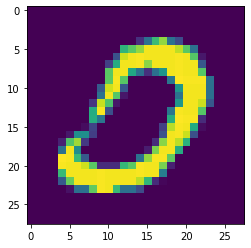

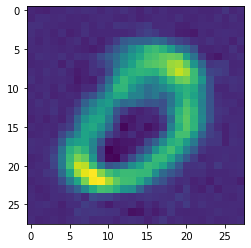

Nuisance image: 
Logits:  [6.1757379e-04 2.0346815e-05 7.0465002e-03 2.4379322e-05 8.0388533e-03
 6.9546432e-04 9.8331547e-01 2.6566483e-06 2.1122108e-04 2.7606979e-05]
Predicted:  6
Real:  6


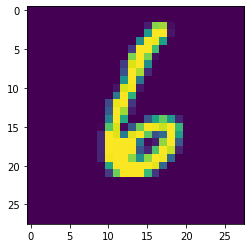

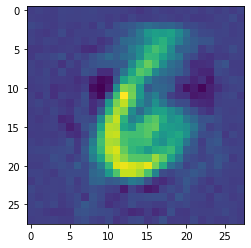

Metameric image


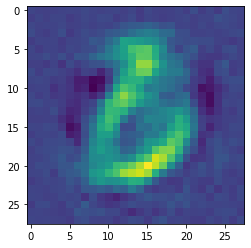


Logit image: 
Logits:  [9.5429379e-01 9.1934135e-06 1.3449634e-03 2.0827359e-02 5.6490677e-08
 2.2373492e-02 3.6802367e-06 1.1066248e-03 1.3928372e-05 2.6872407e-05]
Predicted:  0
Real:  0


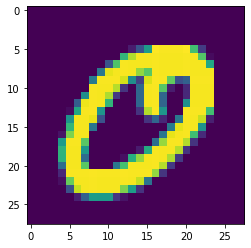

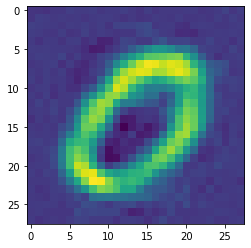

Nuisance image: 
Logits:  [1.8924547e-02 1.1901174e-03 4.8959121e-02 2.2119340e-04 2.2395779e-03
 2.1568531e-02 8.9834911e-01 2.3847310e-06 8.5327895e-03 1.2684461e-05]
Predicted:  6
Real:  6


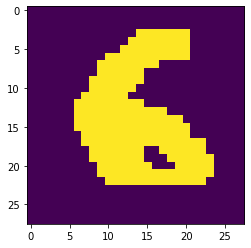

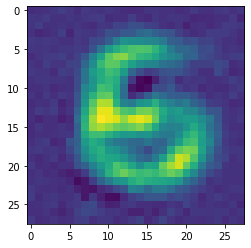

Metameric image


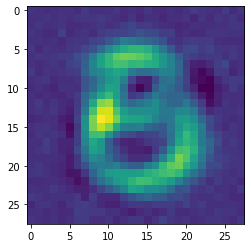


Logit image: 
Logits:  [2.3991549e-02 9.2526619e-07 1.5034017e-04 6.1378581e-04 2.1922272e-03
 5.3601171e-04 5.7255525e-06 8.0814928e-01 5.6121473e-05 1.6430414e-01]
Predicted:  7
Real:  7


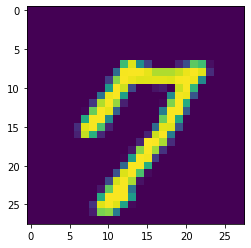

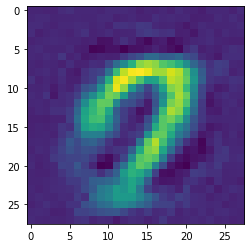

Nuisance image: 
Logits:  [3.9230619e-02 4.4985354e-04 2.8342386e-03 1.1849321e-02 4.0797374e-04
 8.7859225e-01 2.9203700e-02 7.1946051e-06 3.7170388e-02 2.5449396e-04]
Predicted:  5
Real:  5


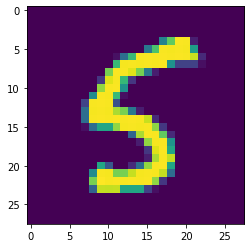

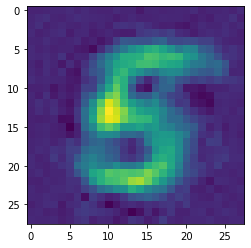

Metameric image


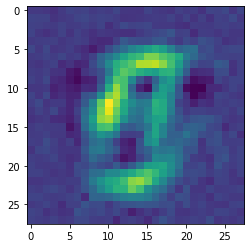


Logit image: 
Logits:  [7.1703722e-03 8.0675643e-05 5.1028276e-04 2.6885550e-02 1.6566162e-05
 9.5652801e-01 9.3278114e-04 1.3604171e-06 7.7700489e-03 1.0438253e-04]
Predicted:  5
Real:  5


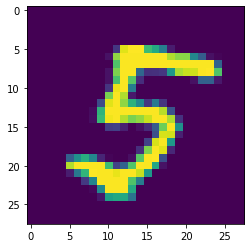

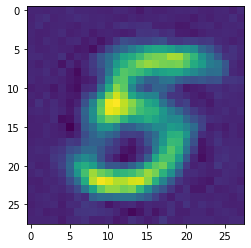

Nuisance image: 
Logits:  [1.8844388e-05 2.7985443e-04 8.8026049e-03 9.8759496e-01 9.8759472e-09
 2.3143687e-03 1.6760011e-06 3.8467821e-05 9.2373503e-04 2.5572655e-05]
Predicted:  3
Real:  3


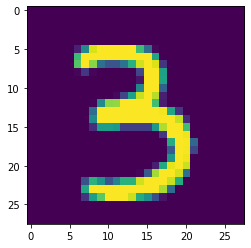

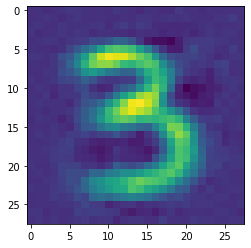

Metameric image


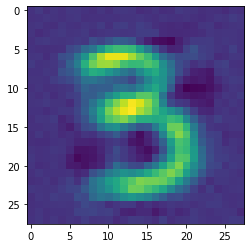


Logit image: 
Logits:  [1.8585454e-03 2.8222783e-05 1.1312516e-02 4.8054793e-05 1.5808171e-02
 1.5126894e-03 9.6913517e-01 4.0584491e-05 1.0133972e-04 1.5484694e-04]
Predicted:  6
Real:  6


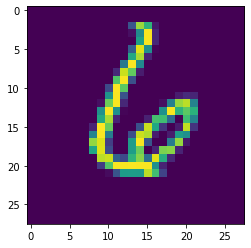

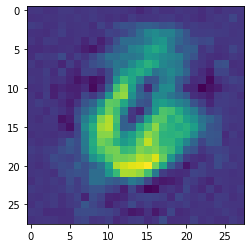

Nuisance image: 
Logits:  [9.8944587e-01 1.6441021e-06 4.1007908e-04 1.4808666e-03 2.6644857e-08
 8.5966671e-03 5.1510611e-05 8.5978591e-06 4.2045804e-06 5.0581309e-07]
Predicted:  0
Real:  0


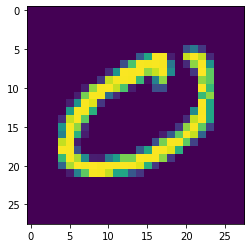

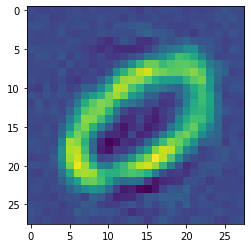

Metameric image


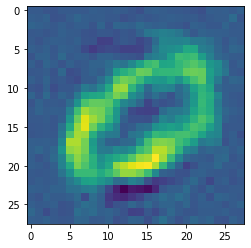


Logit image: 
Logits:  [8.3061110e-05 1.3828556e-03 2.4948224e-02 9.5088017e-01 5.1376958e-07
 4.1059693e-03 1.1560152e-05 3.1996978e-04 1.7955879e-02 3.1172359e-04]
Predicted:  3
Real:  3


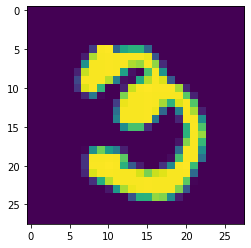

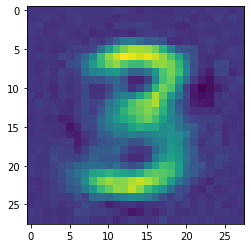

Nuisance image: 
Logits:  [3.2321129e-03 4.6784487e-03 7.4289092e-03 1.7910091e-02 4.9756207e-03
 2.9534644e-01 2.5831736e-03 9.7897559e-05 6.5863299e-01 5.1143472e-03]
Predicted:  8
Real:  8


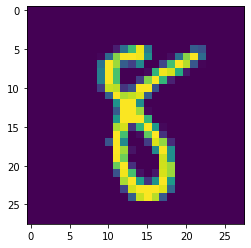

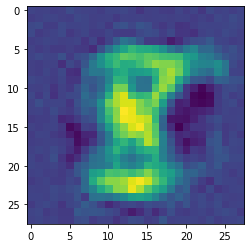

Metameric image


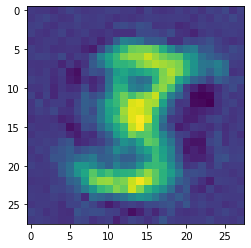


Logit image: 
Logits:  [2.6322095e-04 1.8250439e-04 1.0382156e-02 4.3824228e-04 8.5856837e-01
 5.9708664e-03 3.0607695e-02 2.3002732e-03 7.5147212e-03 8.3771959e-02]
Predicted:  4
Real:  4


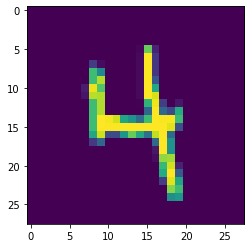

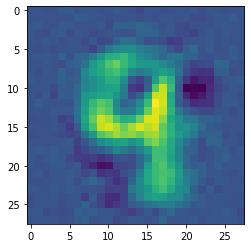

Nuisance image: 
Logits:  [3.6204954e-06 9.6247649e-01 7.4656107e-03 1.5801571e-02 1.7379679e-06
 5.9248030e-04 1.0233295e-05 5.5541298e-03 8.0189779e-03 7.5064316e-05]
Predicted:  1
Real:  1


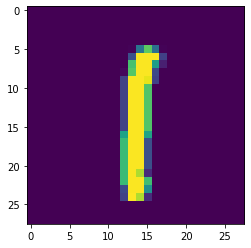

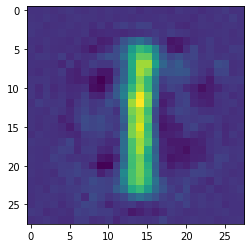

Metameric image


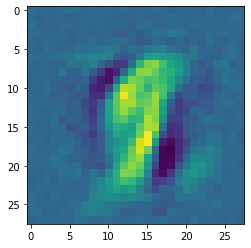


Logit image: 
Logits:  [1.9863242e-04 2.6410775e-05 1.8760525e-02 6.0419126e-05 8.0640279e-03
 2.1065594e-04 9.7213811e-01 2.9236808e-06 5.0502905e-04 3.3404820e-05]
Predicted:  6
Real:  6


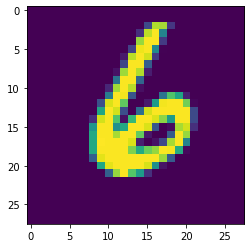

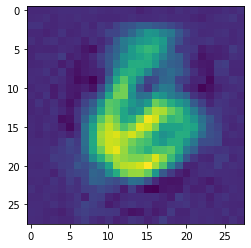

Nuisance image: 
Logits:  [3.4092707e-04 1.6465156e-04 1.3420500e-02 2.3677692e-04 8.7458223e-01
 5.4748221e-03 3.3711746e-02 2.9016673e-03 3.0088129e-03 6.6157848e-02]
Predicted:  4
Real:  4


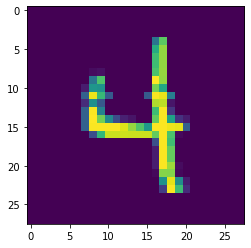

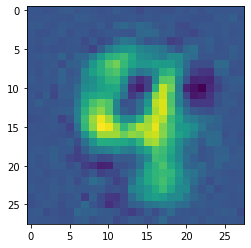

Metameric image


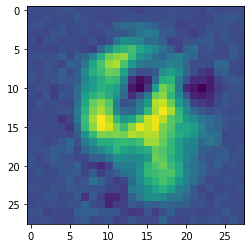


Logit image: 
Logits:  [0.04637292 0.00261292 0.02815133 0.0482549  0.01700069 0.6714244
 0.05258249 0.00241935 0.10493971 0.02624131]
Predicted:  5
Real:  5


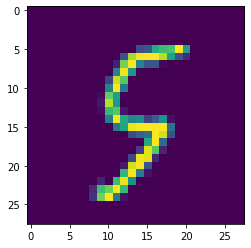

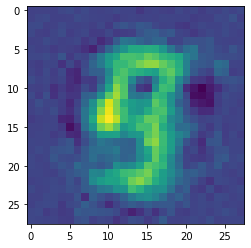

Nuisance image: 
Logits:  [3.89439170e-04 2.74132208e-06 1.06606854e-03 2.97125325e-06
 1.10929534e-02 3.89306224e-04 9.86998498e-01 7.42420241e-07
 4.25005819e-05 1.48418785e-05]
Predicted:  6
Real:  6


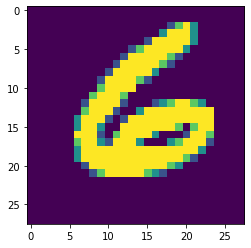

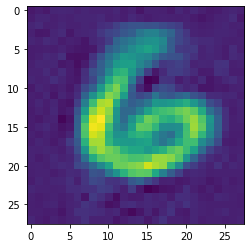

Metameric image


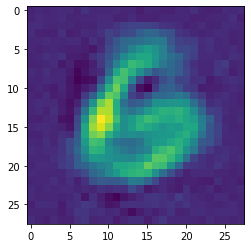


Logit image: 
Logits:  [5.1268199e-03 1.8184311e-03 6.3426038e-03 2.7646939e-03 2.7325612e-02
 9.4979711e-02 3.4397852e-03 9.4544674e-05 8.5175103e-01 6.3568284e-03]
Predicted:  8
Real:  8


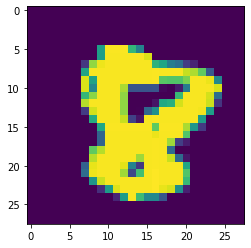

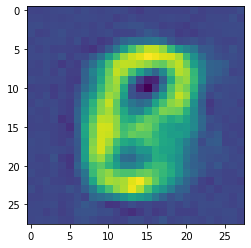

Nuisance image: 
Logits:  [2.2775134e-04 5.7544596e-05 3.9123129e-02 1.4060890e-04 1.0824428e-02
 2.8044128e-04 9.4831771e-01 7.5411567e-06 9.5064344e-04 7.0190465e-05]
Predicted:  6
Real:  6


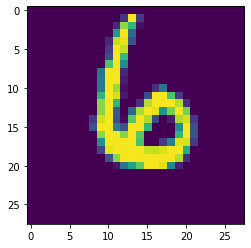

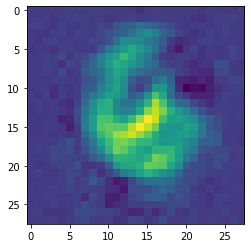

Metameric image


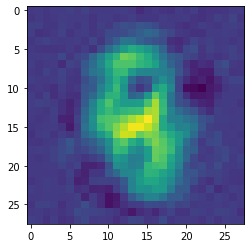

In [45]:
for _ in range(10):
  logit_img, nuisance_img = choose_images(model, test, 0.6)

  _, nuisance, _, _ = model(nuisance_img, training=False)
  logits, _, _, _ = model(logit_img, training=False)

  print("Metameric image")
  met_array = tf.concat([logits, nuisance], axis=-1)
  metameric_img = model._decoder(met_array)
  plt.imshow(tf.reshape(metameric_img, (28, 28)).numpy())
  plt.show()
  print()

Logit image: 
Logits:  [9.8658389e-01 1.3676024e-05 1.0246797e-03 3.5494717e-03 2.2233028e-06
 7.4463054e-03 8.4590509e-05 1.0688032e-03 1.6833519e-04 5.8005902e-05]
Predicted:  0
Real:  0


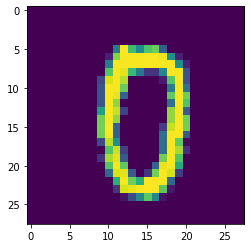

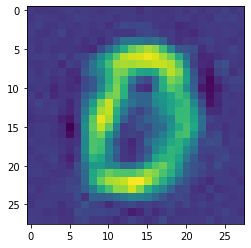

Nuisance image: 
Logits:  [1.0084555e-04 3.5104391e-04 1.1838748e-02 9.8171014e-01 2.2891054e-08
 4.6412321e-03 5.1731176e-06 6.9384208e-05 1.2484542e-03 3.5034940e-05]
Predicted:  3
Real:  3


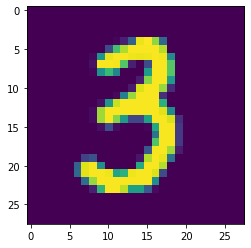

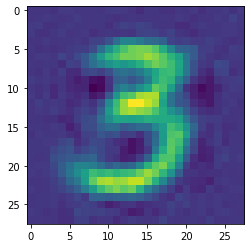

Metameric image


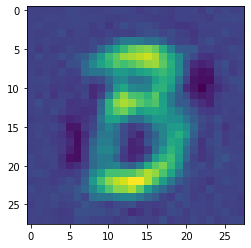


Logit image: 
Logits:  [1.2308151e-02 2.8670381e-04 2.4667496e-03 8.9039125e-02 8.5035077e-04
 8.4688264e-01 4.4415807e-04 1.4545936e-03 1.7216517e-02 2.9050916e-02]
Predicted:  5
Real:  5


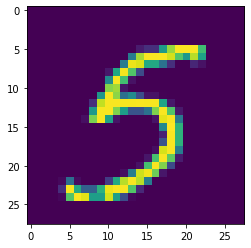

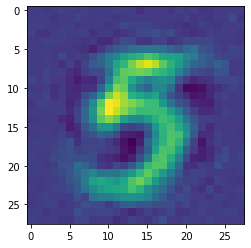

Nuisance image: 
Logits:  [1.52021542e-01 4.13999707e-03 7.12150335e-01 1.15552194e-01
 2.08188180e-06 4.30428516e-03 1.78796196e-04 9.77443252e-03
 1.78877881e-03 8.75486221e-05]
Predicted:  2
Real:  2


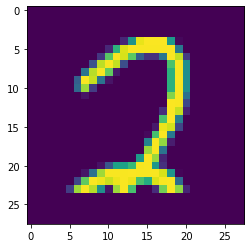

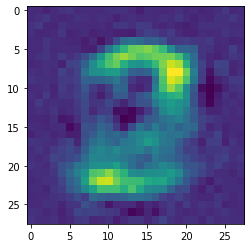

Metameric image


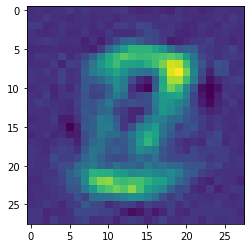


Logit image: 
Logits:  [1.7022867e-06 9.4919193e-01 6.8485411e-03 1.3652912e-03 5.5613422e-05
 3.0878509e-04 8.8858260e-06 2.9541235e-03 3.9047446e-02 2.1775466e-04]
Predicted:  1
Real:  1


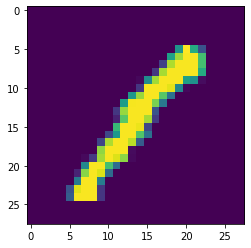

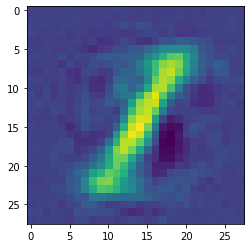

Nuisance image: 
Logits:  [1.4373312e-04 6.1567297e-04 1.7013509e-02 9.6913618e-01 2.6443837e-07
 5.8763223e-03 1.0700821e-06 5.4310646e-04 6.1941119e-03 4.7605296e-04]
Predicted:  3
Real:  3


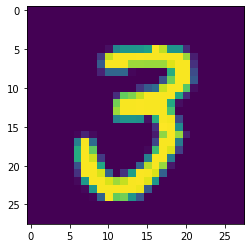

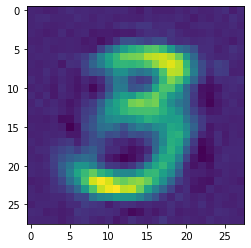

Metameric image


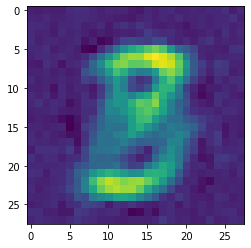


Logit image: 
Logits:  [2.2129783e-04 4.4713879e-04 4.0604325e-05 1.2995294e-04 1.0800072e-05
 2.0995451e-05 2.1657269e-07 9.9800617e-01 1.7174139e-05 1.1056763e-03]
Predicted:  7
Real:  7


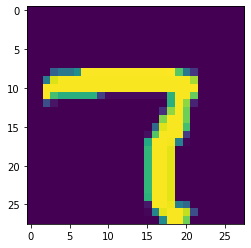

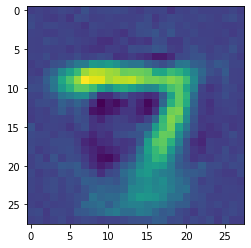

Nuisance image: 
Logits:  [9.9430877e-01 1.6529933e-07 3.0213503e-05 1.2045635e-04 2.2411017e-08
 5.4138512e-03 1.2208297e-04 8.1038678e-08 4.4497051e-06 3.5396827e-08]
Predicted:  0
Real:  0


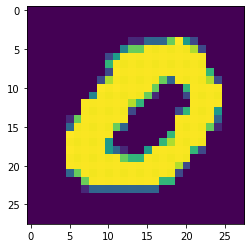

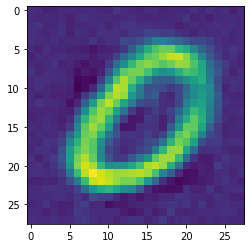

Metameric image


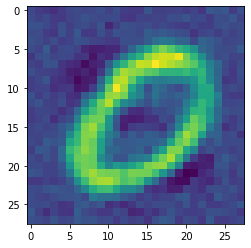


Logit image: 
Logits:  [3.3811677e-05 5.6731229e-04 7.2657742e-02 2.6048040e-03 7.1567458e-01
 9.8753476e-04 1.5727066e-02 1.5231349e-03 9.7098865e-02 9.3125097e-02]
Predicted:  4
Real:  4


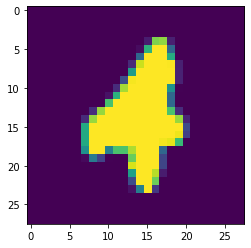

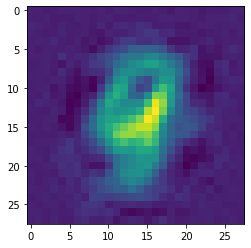

Nuisance image: 
Logits:  [7.1609463e-03 2.0625657e-06 1.2748211e-04 5.6762202e-04 2.7110029e-03
 5.6152878e-04 6.5122517e-06 8.0593282e-01 5.8352769e-05 1.8287168e-01]
Predicted:  7
Real:  7


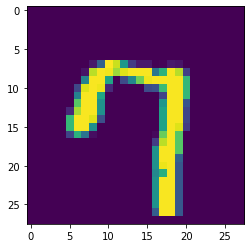

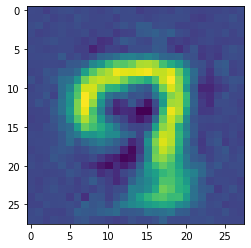

Metameric image


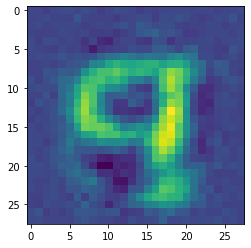


Logit image: 
Logits:  [3.2170038e-03 6.3037318e-05 6.9376803e-03 3.4304743e-05 6.7652874e-03
 4.0062498e-03 9.7821361e-01 2.0440691e-06 7.3767739e-04 2.2987777e-05]
Predicted:  6
Real:  6


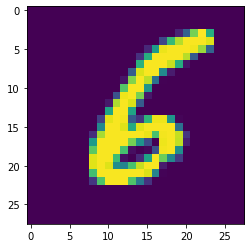

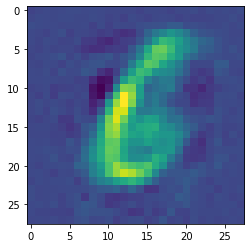

Nuisance image: 
Logits:  [2.0095105e-04 2.7675801e-03 1.6471293e-02 4.1110486e-02 5.3324964e-04
 8.3441203e-03 2.0843875e-04 1.2607643e-04 9.2755264e-01 2.6851564e-03]
Predicted:  8
Real:  8


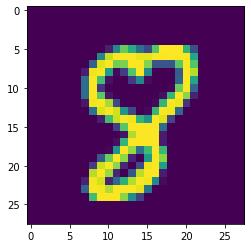

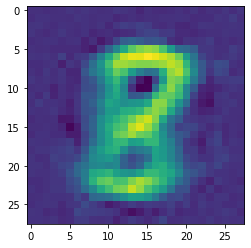

Metameric image


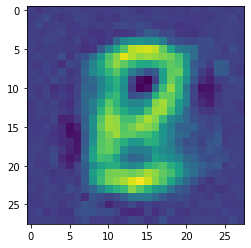


Logit image: 
Logits:  [3.2113112e-05 1.5934474e-04 1.5945405e-04 5.0940888e-04 1.0437734e-04
 9.6030844e-06 8.1801869e-07 9.8900270e-01 8.2191291e-05 9.9400328e-03]
Predicted:  7
Real:  7


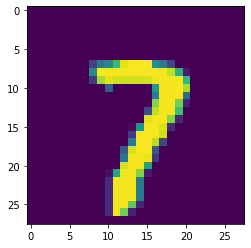

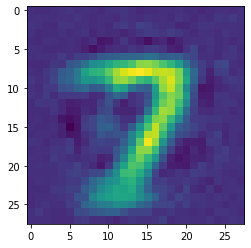

Nuisance image: 
Logits:  [1.3199168e-03 1.3026471e-03 9.8783034e-01 9.2916293e-03 2.6584059e-08
 8.5142477e-05 5.2372336e-05 5.4858210e-05 6.2742423e-05 3.1375023e-07]
Predicted:  2
Real:  2


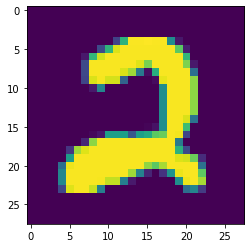

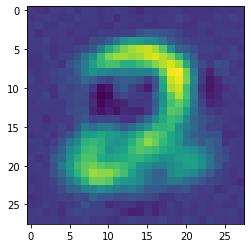

Metameric image


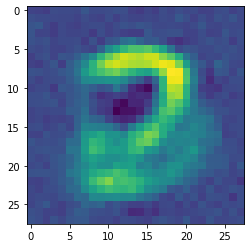


Logit image: 
Logits:  [9.5130395e-05 1.4202898e-04 7.6851090e-03 5.9262529e-05 9.3559581e-01
 1.9843250e-03 1.2111817e-02 1.5117745e-03 2.0071049e-03 3.8807612e-02]
Predicted:  4
Real:  4


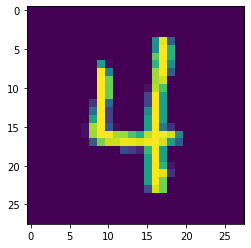

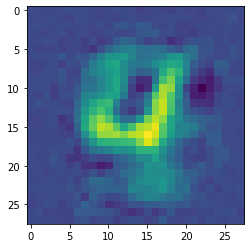

Nuisance image: 
Logits:  [2.0455052e-04 9.3093785e-03 9.7219199e-01 7.7487943e-03 7.7833629e-06
 2.9348469e-04 3.0770444e-03 3.4797187e-05 7.1262871e-03 5.9471049e-06]
Predicted:  2
Real:  2


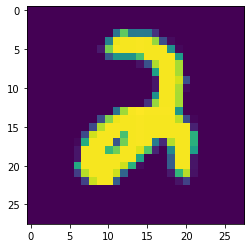

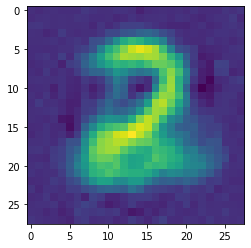

Metameric image


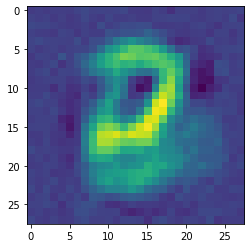


Logit image: 
Logits:  [2.2199265e-04 2.4993760e-03 1.1645296e-02 7.3428881e-01 7.4869626e-05
 1.2758720e-01 3.9969154e-06 1.8604362e-02 2.2222890e-02 8.2851268e-02]
Predicted:  3
Real:  3


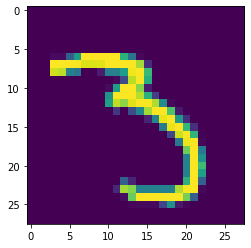

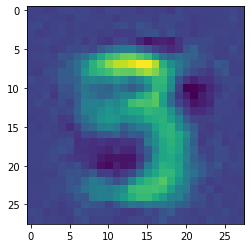

Nuisance image: 
Logits:  [4.8422062e-06 9.6039921e-01 2.9599762e-02 1.2554901e-03 1.7440598e-05
 1.7894633e-04 1.1621063e-04 6.4724674e-03 1.9100974e-03 4.5651264e-05]
Predicted:  1
Real:  1


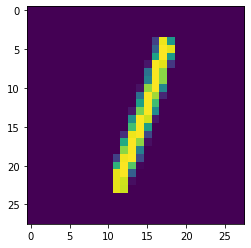

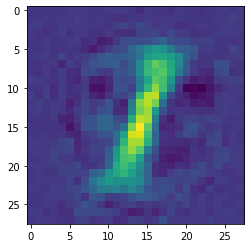

Metameric image


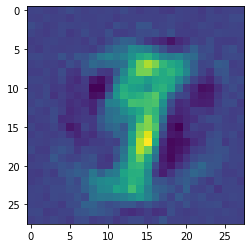


Logit image: 
Logits:  [6.9090351e-04 1.3104943e-05 5.2719978e-03 2.3438362e-05 1.1449477e-02
 8.2887226e-04 9.8154920e-01 5.6669692e-06 1.1294468e-04 5.4545850e-05]
Predicted:  6
Real:  6


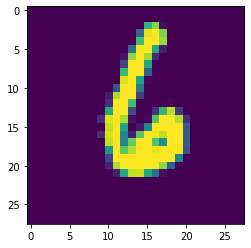

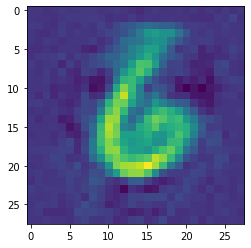

Nuisance image: 
Logits:  [8.9441085e-01 9.5995070e-05 5.4315306e-02 7.8880944e-04 1.6192412e-04
 6.8176407e-03 4.2380966e-02 8.9790276e-04 8.0479971e-05 5.0086132e-05]
Predicted:  0
Real:  0


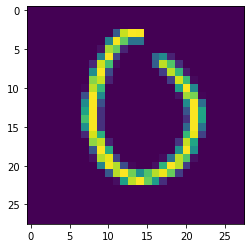

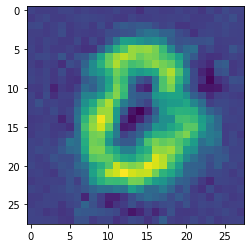

Metameric image


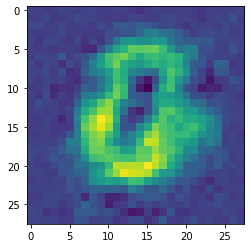

In [47]:
for _ in range(10):
  logit_img, nuisance_img = choose_images(model, test, 0.6)

  _, nuisance, _, _ = model(nuisance_img, training=False)
  logits, _, _, _ = model(logit_img, training=False)

  print("Metameric image")
  met_array = tf.concat([logits, nuisance], axis=-1)
  metameric_img = model._decoder(met_array)
  plt.imshow(tf.reshape(metameric_img, (28, 28)).numpy())
  plt.show()
  print()